# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# general libraries
import dotenv
import glob
import os
import pathlib
import site
import sys
import warnings
from tqdm.dask import TqdmCallback as ProgressBar
# data handling libraries
import geopandas as gpd
import numpy as np
import pandas as pd
import rioxarray as rxr
import xarray as xr
# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning libraries
import gpytorch
from sklearn import gaussian_process as gp
import torch

import pamir_mlpermafrost as pamir

In [3]:
sns.set_style('white')

plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['font.size'] = 12

# Data exploration

Data should have been prepared with the `../../pamir-CryoGrid/` package and should be in Zarr format.  
This zarr file can live either on disk or in a cloud storage bucket. Make sure that you have a `.env` file if you're using an S3 bucket.  

## Data loading


In [4]:
table = pd.read_parquet('../data/training/training_data-k1500-pamir_ns180-expX.parquet')

table = pd.read_parquet('../data/training/training_data-k1500-pamir_ns180-expX.parquet')
table['surface_index'] = table.stratigraphy_index % 4 + 1
table = pamir.data.dem_utils.calc_aspect_cos_sin(table)

In [5]:
target = 'active_layer_thickness'
features = [
    'altitude',
    'slope_angle',
    'aspect_cos',
    'aspect_sin',
    'albedo',
    'emissivity',
    'temperature',
    'precipitation',
    'snow_melt_doy',
]

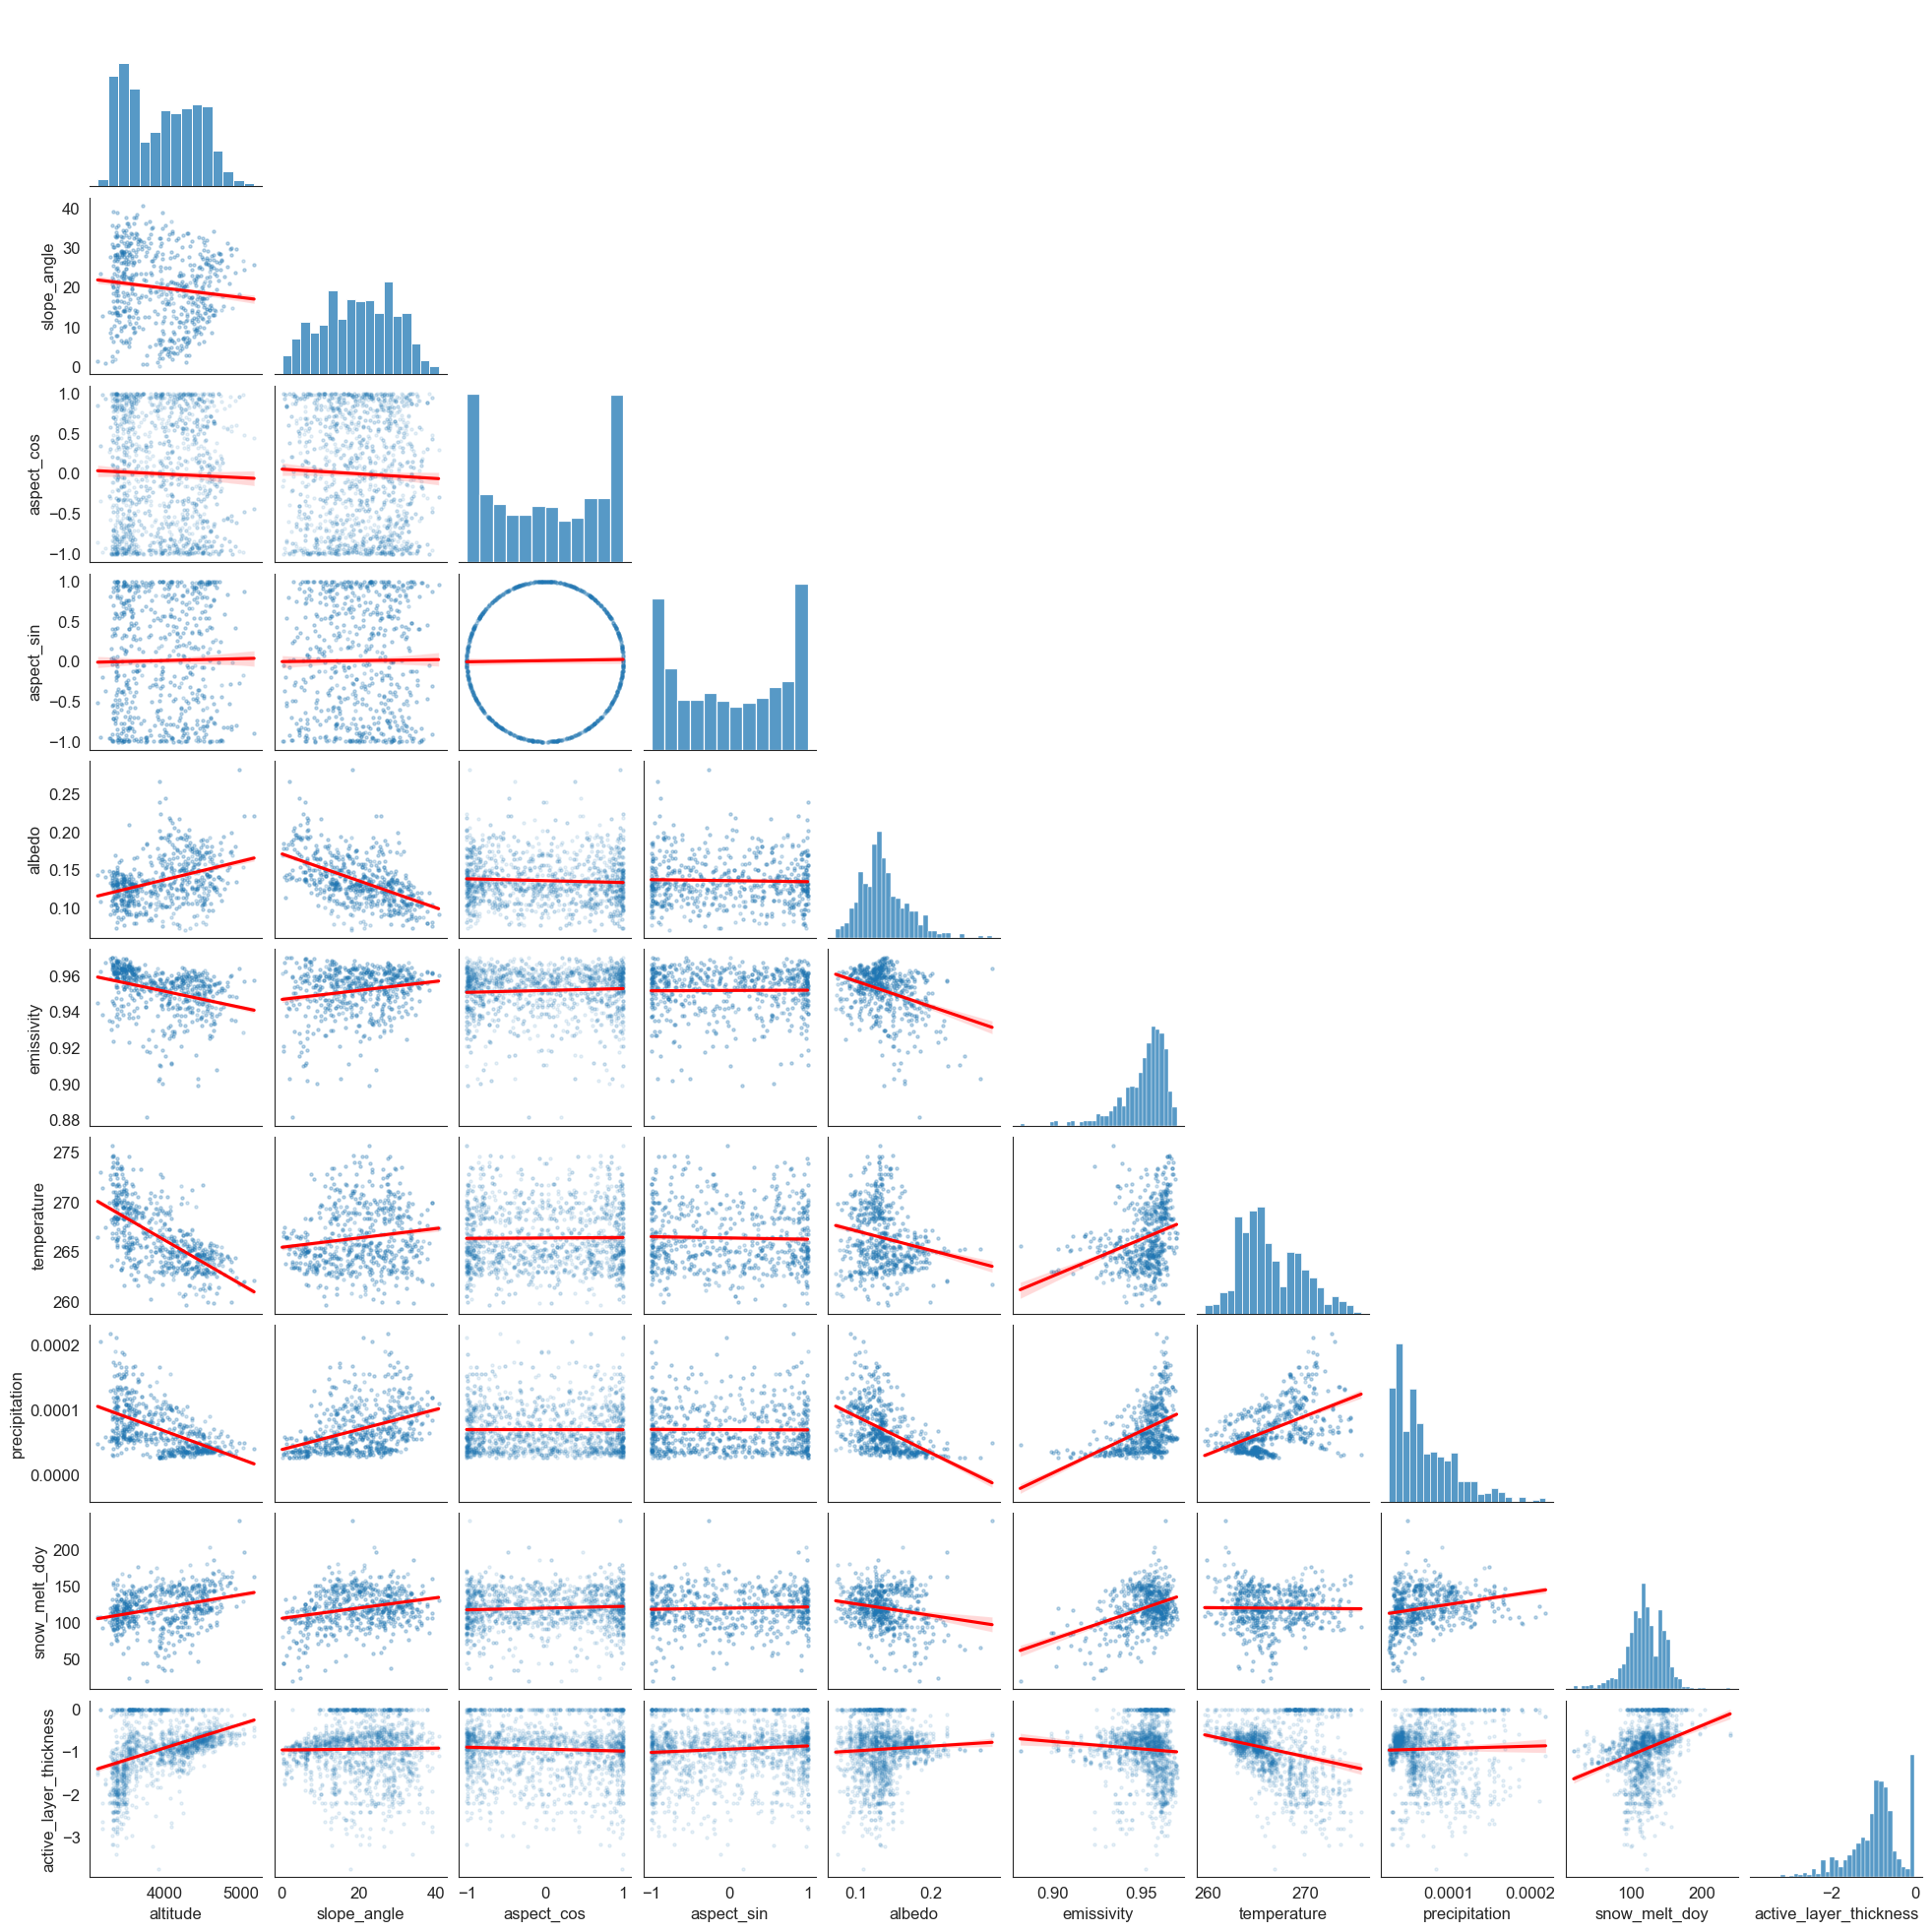

In [6]:
sns.pairplot(
    data=table[table.surface_index == 1], 
    vars=features + [target], 
    # hue='surface_index', 
    # palette=sns.color_palette('turbo', n_colors=4),
    kind='reg',
    plot_kws={'scatter_kws': {'alpha': 0.1, 's': 5}, 'line_kws': {'color': 'red'}},
    corner=True,
    height=2,
)

<Axes: xlabel='variable', ylabel='variable'>

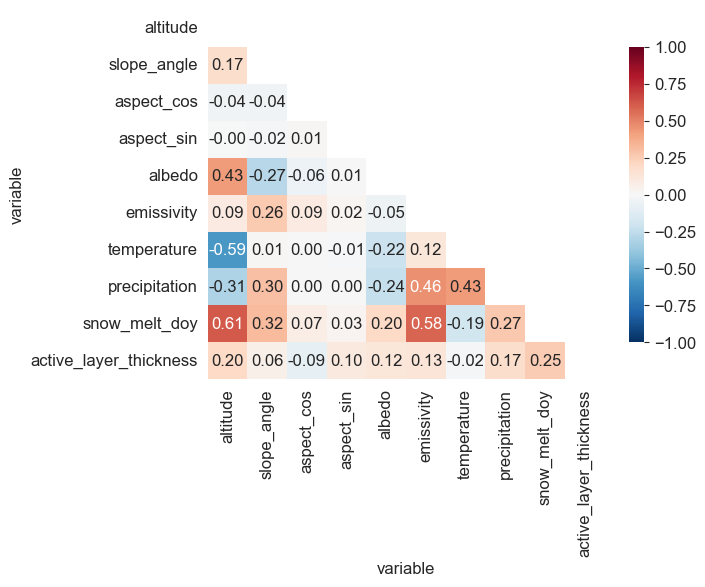

In [7]:
corr_table = (table[features + [target]].corr())
sns.heatmap(
    corr_table, 
    annot=True, 
    fmt=".2f", 
    cmap='RdBu_r', 
    square=False,
    mask=np.triu(corr_table, k=0), 
    cbar_kws={"shrink": .8},
    vmin=-1, vmax=1,
    
)

In [34]:
slopes = (
    da_active_layer
    .groupby('time_1YS.year').mean()
    .polyfit(dim='year', deg=1)
    .polyfit_coefficients
    .rename('slope')
    .pipe(lambda x: x * 10)
    .sel(degree=1, drop=True)
    .to_series())

df_X[f'{target}_slope'] = slopes

Text(0.5, 13.722222222222216, 'Active layer thickness change [m / decade]')

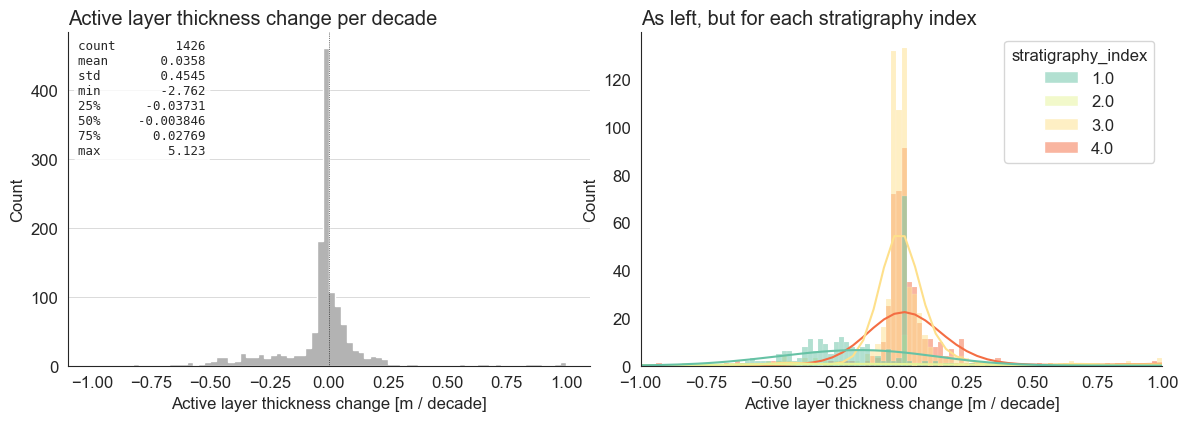

In [35]:
key = f'{target}_slope'

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax0 = pamir.viz.stats.plot_hist_from_series(df_X[key], ax=axs[0], bins=np.arange(-1, 1.01, 0.025))[1]
# ax0.set_yscale('log')
ax0.set_title('Active layer thickness change per decade', loc='left')
ax0.set_xlabel('Active layer thickness change [m / decade]')

ax1 = sns.histplot(
    data=df_X,
    x=key,
    hue='stratigraphy_index',
    binrange=(-1, 1),
    binwidth=0.02,
    palette=sns.color_palette('Spectral_r', n_colors=4),
    kde=True,)
ax1.set_xlim(-1, 1)
ax1.set_title('As left, but for each stratigraphy index', loc='left')
ax1.set_xlabel('Active layer thickness change [m / decade]')

In [29]:
df_X.to_parquet(fname_training)